Image feature detection and description created by Alex Frye, for use in Dr. Hoover's EE/CENG 441/541 Computer Vision class

In [1]:
import skimage
from skimage import io
from skimage import data
from skimage.transform import resize
from skimage.transform import rotate
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as LA
import time
from scipy import signal
from scipy.ndimage import gaussian_filter

from Lab2_lib import *

In [2]:
header = 'P2Images/'
im_per_group = 6
im_titles = ['bikes/', 'graf/', 'leuven/', 'wall/']
im_set = [[], [], [], []];
im_set_gray = [[], [], [], []];
for i in range(len(im_titles)):
    title = header + im_titles[i]
    for j in range(im_per_group):
        im_set[i].append(io.imread(title + 'img' + str(j+1) + '.ppm'))
        im_set_gray[i].append(skimage.color.rgb2gray(io.imread(title + 'img' + str(j+1) + '.ppm')))

im_yosemite = [io.imread('P2Images/Yosemite/Yosemite1.jpg'), io.imread('P2Images/Yosemite/Yosemite2.jpg')]
im_yosemite_gray = [skimage.color.rgb2gray(im_yosemite[0]), skimage.color.rgb2gray(im_yosemite[1])]
im_triangle = io.imread('P2Images/triangle.png')
im_triangle_gray = skimage.color.rgb2gray(im_triangle)
im_checkerboard = io.imread('P2Images/checkerboard.jpg')
im_checkerboard_gray = skimage.color.rgb2gray(im_checkerboard)


Step 1: Feature Extraction

In this program, features are extracted using a Harris corner detector (without any scale invariance). For each pixel in the image, a Harris matrix is created, and the magnitude of the 'corner-ness' is computed using the determinant divided by the trace. The gradient angle is also computed, as the arc-tangent of the y-derivative over the x-derivative. These features are thresholded to remove noise, and then the local maxima are found.

(Here is an implementation of adaptive non-maximum suppression)
These local maxima are found by starting at a point every certain number of pixels (usually 3, since every 1 is wasteful). At each point, the magnitude is compared to the magnitudes of its neighbors, and if one is higher, the new point is stored. If the current point is a local maximum (no ajacent point is higher), then the coordinates are stored in a local_max variable and returned at the end of the function. After each current point has been looked at, the stored points from the last iteration are moved to the current points and the process is repeated until there are no more points. When that occurs, the local_max array is returned. This is compute-intensive, but produces good results no matter the illumination conditions, unlike thresholding.

An example of some detected features is shown below. 

The first image is the input image, concatenated with the corner-strength image, concatenated with the local-maxima image. (It should be noted that there are 854 local maxima, but the small image doesn't show quite all of them).

The second image is features drawn over the top of the first Yosemite image, with a threshold of 0.3.

The third image is features drawn over the top of the first Yosemite image, with a threshold of 0.5. This higher threshold removes some of the weaker corners, but also removes possible matches from future computations. 

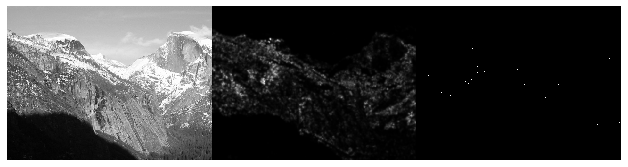

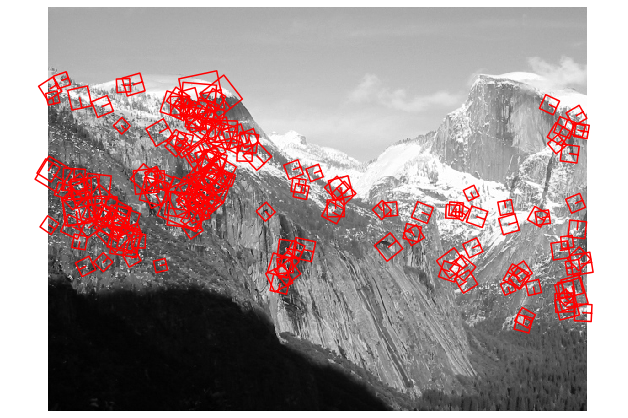

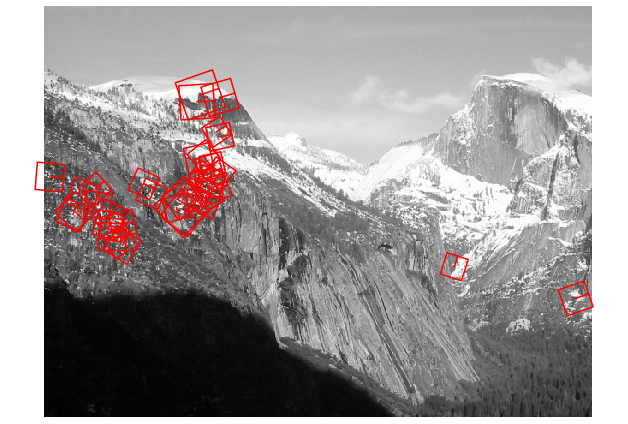

In [3]:
im0 = im_yosemite_gray[0]

im_corner, tmp = detect_corners_harris(im0)
im_corner_filt, tmp, tmp = local_maxima_descent(im_corner)

ajacent_images([im0, im_corner, im_corner_filt])

plot_boxes_im(im0)
plot_boxes_im(im0, threshold=0.5)

Step 2: Feature description

Now that features have been found in the images, they need descriptors so later they can be matched together. The descriptors used here are invariant to orientation and illumination, but not scale or perspective.

Each feature is taken (location (x, y) and orientation (angle in radians)), and the descriptor is computed. First, an 11x11 patch around the feature is taken, and rotated until the gradient orientation is parallel with the x axis. Next, a 5x5 chunk is taken from that rotated patch. Finally, the 5x5 patch is flattened into a single 1x25 vector, and normalized to 1. The values stored with the descriptor are:
    Location (x, y in pixels)
    Gradient angle (radians)
    Gradient magnitude
    1x25 vector of local image information

An example desctiptor is show below, with 5x5 patch and red box for angle

[array([78,  5]), array([-2.55039459]), array([0.10931795]), array([[0.1925668 ],
       [0.18948214],
       [0.20904688],
       [0.22964609],
       [0.22913119],
       [0.17660422],
       [0.17909657],
       [0.19802256],
       [0.2144296 ],
       [0.23176694],
       [0.17042346],
       [0.17180713],
       [0.18783549],
       [0.22381106],
       [0.24135652],
       [0.18319181],
       [0.19167759],
       [0.21512244],
       [0.21437256],
       [0.20098339],
       [0.18989277],
       [0.21412533],
       [0.17880612],
       [0.16417069],
       [0.17307203]])]


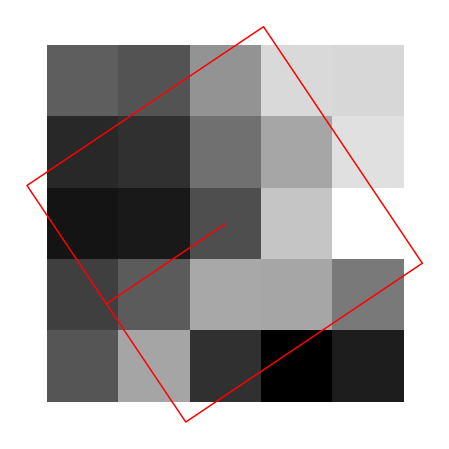

In [4]:
im0 = im_yosemite_gray[0]
d0 = features_descriptors(im0, s1=1, s2=2, pix_dist=3, threshold=0.1)

print(d0[0])

ajacent_images(np.reshape(d0[0][3], (5, 5)))
showFeatures([2, 2], 50 * d0[0][2][0], d0[0][1][0])

Step 3: Feature Matching

Features with descriptors are matched by two methods: either threshold or ratio of best/second best

threshold:
For each feature in the first image, the distance between it and each feature in the second image is computed. Starting with the best match, if this distance is below a certain threshold, then it is accepted and both features are stored in a match array. When a match fails the threshold test, then every other match is guaranteed to fail the test as well, since the program has been stepping up in match score, so the function returns the current matches.

Comparison of threshold and ratio methods:

The next 2 images are a comparison of the threshold and ratio methods on the same image inputs. They both function quite well when tuned properly, but fail when not. There isn't much of a difference in performance between the two in these images.

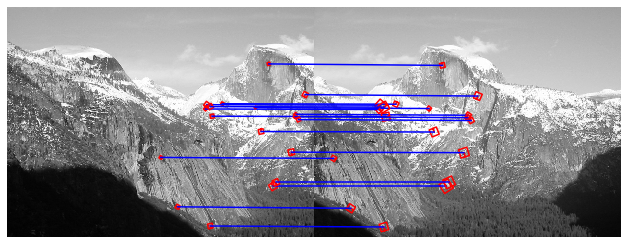

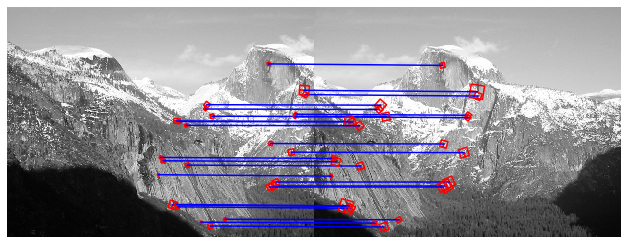

In [5]:
im0 = im_yosemite_gray[0]
im1 = im_yosemite_gray[1]
[im0, im1] = make_images_same_size([im0, im1])

d0 = features_descriptors(im0, s1=1, s2=2, pix_dist=3, threshold=0.1)
d1 = features_descriptors(im1, s1=1, s2=2, pix_dist=3, threshold=0.1)
matches = np.array(compare_features_threshold(d0, d1, threshold=0.032))
connect_features(matches, im0, im1)

d0 = features_descriptors(im0, s1=1, s2=2, pix_dist=3, threshold=0.1)
d1 = features_descriptors(im1, s1=1, s2=2, pix_dist=3, threshold=0.1)
matches2 = np.array(compare_features_ratio(d0, d1, threshold=2))
connect_features(matches2, im0, im1)

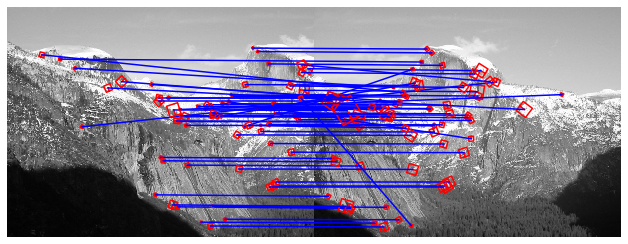

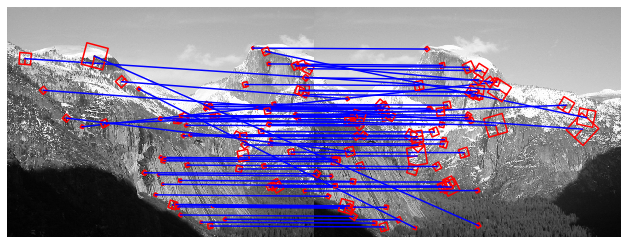

In [6]:
d0 = features_descriptors(im0, s1=1, s2=2, pix_dist=3, threshold=0.1)
d1 = features_descriptors(im1, s1=1, s2=2, pix_dist=3, threshold=0.1)
matches = np.array(compare_features_threshold(d0, d1, threshold=0.05))
connect_features(matches, im0, im1)

d0 = features_descriptors(im0, s1=1, s2=2, pix_dist=3, threshold=0.1)
d1 = features_descriptors(im1, s1=1, s2=2, pix_dist=3, threshold=0.1)
matches2 = np.array(compare_features_ratio(d0, d1, threshold=1.4))
connect_features(matches2, im0, im1)

Other examples:

Next are two additional comparisons between images. Both sets of images have slight perspective shifts.

The first, the images of bikes, works acceptable well, correctly matching 5/6 of the features.

The second, the images of the brick wall, is actually fairly impressive. The program can correctly identify features in the midst of all of the clutter and noise of illumination and (admittedly slight) perspective changes, along with the repetetive nature of bricks. 

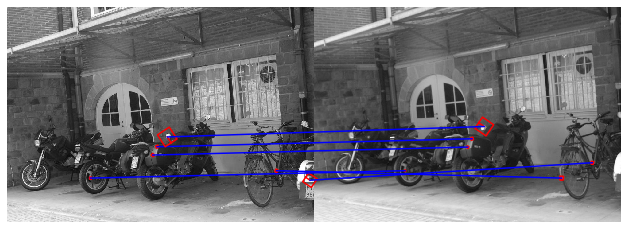

In [7]:
im0 = im_set_gray[0][0]
im1 = im_set_gray[0][1]
[im0, im1] = make_images_same_size([im0, im1])

d0 = features_descriptors(im0, s1=3, s2=4, pix_dist=3, threshold=0.1)
d1 = features_descriptors(im1, s1=3, s2=4, pix_dist=3, threshold=0.1)
matches = np.array(compare_features_threshold(d0, d1, threshold=0.027))
connect_features(matches, im0, im1)

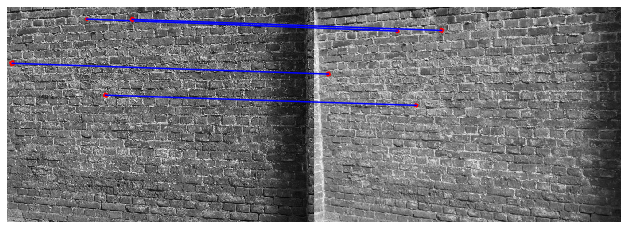

In [8]:
im0 = im_set_gray[3][0]
im1 = im_set_gray[3][1]
[im0, im1] = make_images_same_size([im0, im1])

d0 = features_descriptors(im0, s1=3, s2=4, pix_dist=3, threshold=0.1)
d1 = features_descriptors(im1, s1=3, s2=4, pix_dist=3, threshold=0.1)
matches = np.array(compare_features_threshold(d0, d1, threshold=0.029))
connect_features(matches, im0, im1)

Invariance to translation, rotation, and illumination:

This descriptor and feature detection method is strongly invariant to the above, as can be seen in the next image.

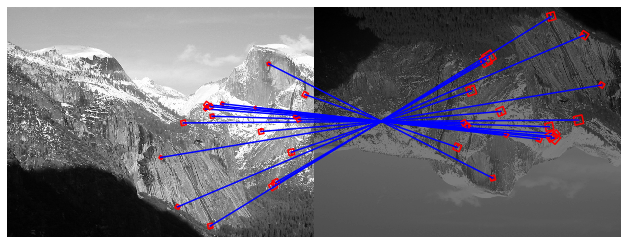

In [9]:
im0 = im_yosemite_gray[0]
im1 = 1/2 * rotate(im_yosemite_gray[1], 180)
[im0, im1] = make_images_same_size([im0, im1])

d0 = features_descriptors(im0, s1=1, s2=2, pix_dist=3, threshold=0.1)
d1 = features_descriptors(im1, s1=1, s2=2, pix_dist=3, threshold=0.1)
matches = np.array(compare_features_threshold(d0, d1, threshold=0.032))
connect_features(matches, im0, im1)